## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 10000 reviews by using 'chunksize'. All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=10000))
# If your computer has enough memory, uncomment the line below to use the entire dataset.
# movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')


[nltk_data] Downloading package punkt to
[nltk_data]     D:\Users\edgarjj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 3.24 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

10000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      12

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [5]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 90 ms


In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

**Answer.**

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

### Histograms instant video dataframe

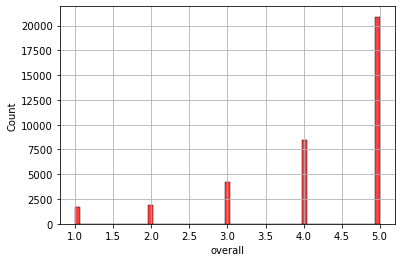

In [8]:
sns.histplot(data=instant_video, x="overall", color = 'red')
plt.grid()

**Analysis:** Well, this histogram shows the ratings obtained by the instan_video dataset, it is interesting to note that the large concentration of the ratings are ratings above 3, where the vast majority have a 5 star rating. In contrast, the lower ratings, between 1 and 2, do not represent a large portion of the dataset, so we quickly realize that this dataset will focus on more positive ratings than negative ones.

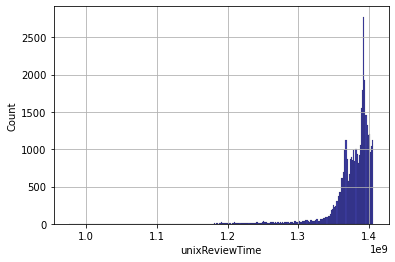

In [9]:
sns.histplot(data=instant_video, x="unixReviewTime", color='darkblue')
plt.grid()

**Analysis:**This histogram of the unixReviewTime column does not really give us much information, although this column is numeric, it corresponds more as an ID than as a value that can be interpreted through this histogram.

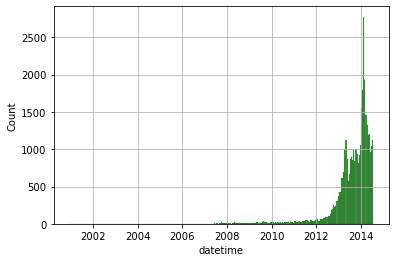

In [10]:
sns.histplot(data=instant_video, x="datetime", color = 'green')
plt.grid()

**Analysis:** This temporal histogram shows that the highest concentration of data is from 2012, although there are some records between 2008 and 2012, these are very few compared to data after 2012. Therefore, we will find that most of the revisions are from more recent years.

### Histograms movies_tv dataframe

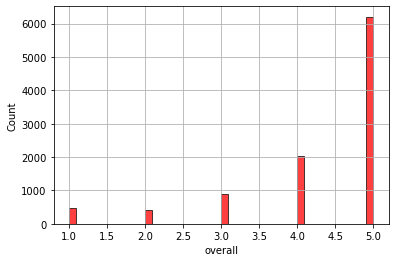

In [11]:
sns.histplot(data=movies_tv, x="overall", color = 'red')
plt.grid()

**Analysis:** Here again we see that the large concentration of the ratings are ratings above 3, where the vast majority have a 5 star rating. In contrast, the lower ratings, between 1 and 2, do not represent a large portion of the dataset, so we quickly realize that this dataset will focus on more positive ratings than negative ones.

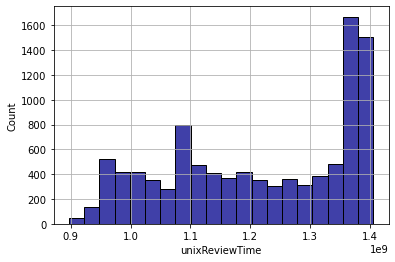

In [12]:
sns.histplot(data=movies_tv, x="unixReviewTime",color='darkblue')
plt.grid()

**Analysis:**This histogram of the unixReviewTime column does not really give us much information, although this column is numeric, it corresponds more as an ID than as a value that can be interpreted through this histogram.

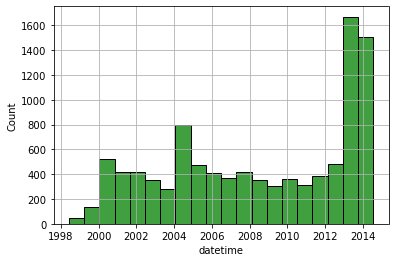

In [13]:
sns.histplot(data=movies_tv, x="datetime", color = 'green')
plt.grid()

**Analysis:** This histogram shows that, although the highest concentration of reviews corresponds to the most recent years (2013-2014), there is also a considerable amount in earlier years (2000-2012) and the difference is not as marked as in the previous case, which practically everything is in more recent years. In this data set, on the contrary, the reviews over time are more stable

-------

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

**Answer.**

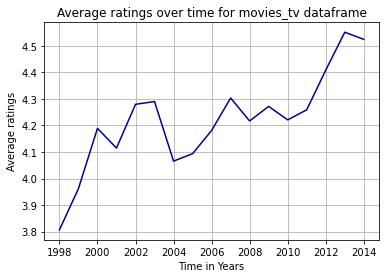

In [14]:
movies_tv.groupby(movies_tv.datetime.dt.year)['overall'].mean().plot(color="darkblue")
plt.title('Average ratings over time for movies_tv dataframe')
plt.xlabel('Time in Years')
plt.ylabel('Average ratings')
plt.grid()

**Analysis:** 
For this data set, movies tv, there is a clear upward trend over the years, where the average rating has been increasing, from 3.8 in 1998 to just over 4.5 in 2014. We find a decrease of almost 0.2 between 2003 and 2004, which may be due to the fact that there were indeed more negative ratings than positive ones, or to a reduction of the total data in this year. In conclusion, this graph represents an upward trend in average ratings.
This histogram shows that, although the highest concentration of reviews corresponds to the most recent years (2013-2014), there is also a considerable amount in earlier years (2000-2012) and the difference is not as marked as in the previous case, which practically everything is in more recent years. In this data set, on the contrary, the reviews over time are more stable. 


**Analysis Average ratings plot movies_tv dataframe** : 

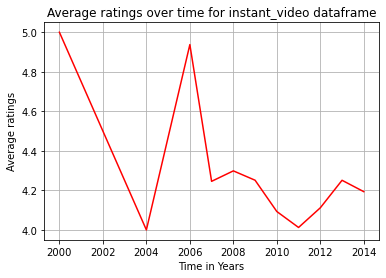

In [15]:
instant_video.groupby(instant_video.datetime.dt.year)['overall'].mean().plot(color="red")
plt.title('Average ratings over time for instant_video dataframe')
plt.xlabel('Time in Years')
plt.ylabel('Average ratings')
plt.grid()

**Analysis:** In this case, it could be said that the trend has a lateral behavior, although there is a sharp drop between 2000 and 2004, from an average of 5 to 4. However, the average rises again to 4.8 for 2006 and for the following years the values seem to be more stable and oscillate around an average of 4.2. These large fluctuations in the early years may be due to the scarcity of data and the high standard deviation.

-------

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

<AxesSubplot:xlabel='datetime'>

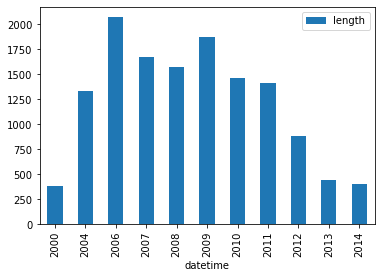

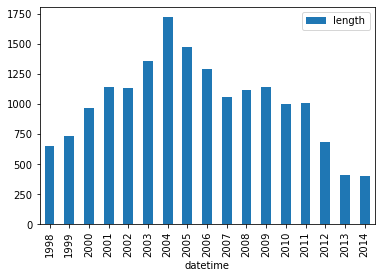

In [16]:
instant_video['length'] = instant_video['reviewText'].apply(len)
instant_video.groupby(instant_video.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

movies_tv['length'] = movies_tv['reviewText'].apply(len)
movies_tv.groupby(movies_tv.datetime.dt.year)['length'].mean().to_frame().plot(kind="bar")

**Answer.**  Yes, this graph shows the length of the revisions over the years, clearly we can see that for the previous years between 2000 and 2006 the length of the revisions was increasing, i.e., the texts were longer and were getting longer. Now, from 2004-2006, there is a clear decrease in the length of these reviews, reaching its minimum point in 2014, although it is not clear the reason why this happens, an interesting factor may be that with the advent of social networks and their character limit for publications, people get used to it and have shorter messages, but this is a hypothesis only.

-------

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer.**

# Instan video Dataset

## All reviews 

In [17]:
from nltk.corpus import stopwords
import re
import itertools

# Read text column
column_text = instant_video['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('show', 25384),
 ('season', 16907),
 ('one', 14851),
 ('like', 14748),
 ('series', 12903),
 ('good', 12664),
 ('great', 10594),
 ('really', 9097),
 ('love', 8990),
 ('watch', 8989)]

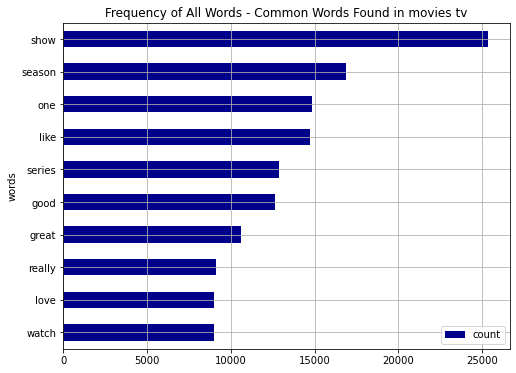

In [18]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='darkblue')
ax.set_title("Frequency of All Words - Common Words Found in movies tv")
plt.grid()
plt.show()

**Analysis:** To calculate these frequent words, the first step is to clear the text column to be analyzed. In this case, all processing is performed on ReviewText (it could also be the Summary column, for example). This data cleaning is mainly focused on the removal of characters that do not contribute to the text analysis, where first the data is converted to lowercase, spaces, exclamation marks, punctuation marks, numeric values, etc. are removed. Subsequently, stop words, which are words that have a high frequency and do not contribute much to the analysis, are cleaned.

After this cleaning process, a tokenization and counting of the words that appear in the text is performed, and then the 10 most frequent words are presented. `Show`, `season` and `one` are the 3 most repeated for the entire dataset.

## Positive reviews 

For this case it is assumed that positive reviews are those that have a rating **greater than or equal to 4.**

In [19]:
# Subset dataset

instant_video_positive = instant_video[instant_video['overall']>= 4]

In [20]:
# Read text column
column_text = instant_video_positive['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('show', 20465),
 ('season', 14274),
 ('series', 10916),
 ('one', 10834),
 ('like', 10206),
 ('good', 9693),
 ('great', 9375),
 ('love', 8004),
 ('watch', 6912),
 ('well', 6718)]

**Analyisis:** Now, the exercise asks to perform the same process as above but for the positive reviews. In this case we will use the rating column in order to extract the records with the best ratings, which are expected to have the most positive reviews. To perform the extraction of these records the following logic was used:

`instant_video_positive = instant_video[instant_video['overall']>= 4]`

Note that we will only consider positive records those that have a score of 4 or 5, this is what I considered as positive, and on this set of data we perform all the cleaning processes discussed above.


For this case we find words that represent positive themes, although they are not reflected in the top 3 as you would expect, but we find words like.  `good`,`like`, `great` and `love`

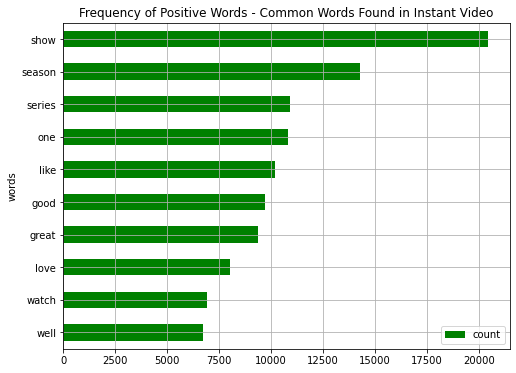

In [21]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='green')
ax.set_title("Frequency of Positive Words - Common Words Found in Instant Video")
plt.grid()
plt.show()

## Negative reviews 

For this case it is assumed that positive reviews are those with a rating **less than 3.**.

In [22]:
# Subset dataset
instant_video_negative = instant_video[instant_video['overall']< 3]

In [23]:
# Read text column
column_text = instant_video_negative['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('show', 2249),
 ('like', 2123),
 ('one', 1865),
 ('movie', 1784),
 ('would', 1237),
 ('film', 1206),
 ('really', 1176),
 ('good', 1148),
 ('time', 1002),
 ('get', 986)]

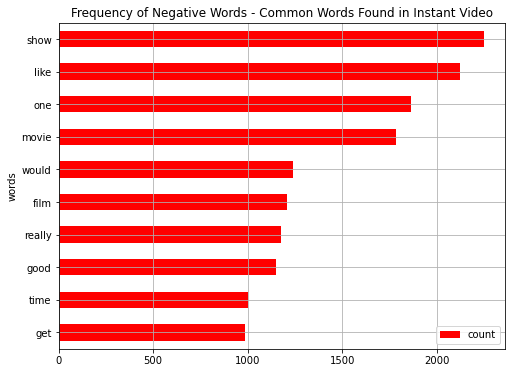

In [24]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='red')
ax.set_title("Frequency of Negative Words - Common Words Found in Instant Video")
plt.grid()
plt.show()

**Analyisis:** Now, the exercise asks to perform the same process as the previous one but for the negative ratings. In this case we will use the ratings column to extract the records with the worst ratings, which are the ones expected to have more negative ratings. The following logic has been used to extract these records:

`instant_video_negative = instant_video[instant_video['overall']< 3]`

It should be noted that we will only consider negative records those with a score of 2 or 1, this is what I have considered as negative, and on this data set we perform all the cleaning processes discussed above.

Unlike the previous point, we do not find very negative context words, on the contrary we find words such as `like`, and `good`, which at first glance seems strange because we are using negative reviews. Let's keep exploring!


## Neutral reviews 

For this case it is assumed that positive reviews are those with a rating **equal than 3.**.

In [25]:
# Subset dataset
instant_video_neutral = instant_video[instant_video['overall']== 3]

In [26]:
# Read text column
column_text = instant_video_neutral['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('show', 2670),
 ('like', 2419),
 ('one', 2152),
 ('good', 1823),
 ('season', 1797),
 ('movie', 1641),
 ('film', 1627),
 ('would', 1460),
 ('really', 1410),
 ('story', 1355)]

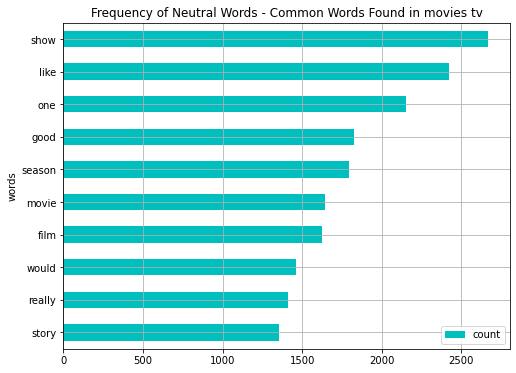

In [27]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='c')
ax.set_title("Frequency of Neutral Words - Common Words Found in movies tv")
plt.grid()
plt.show()

**Analysis:** Now, although the exercise does not ask for it, I performed the same procedure for neutral valuations. These ratings are those that have a rating exactly equal to 3. Since we split the dataset into negative (<3) and positive (>=4), we use this approach to observe the behavior of the neutrals. The logic to extract the data was as follows:

`instant_video_neutral = instant_video[instant_video['overall']== 3]`

**Analysis reviews instant_video dataframe** : 

# Moviest tv Dataset

## All reviews 

In [28]:
# Read text column
column_text = movies_tv['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('movie', 13474),
 ('film', 10666),
 ('one', 8090),
 ('like', 4838),
 ('great', 4330),
 ('good', 4239),
 ('quot', 4106),
 ('story', 3687),
 ('time', 3612),
 ('well', 3468)]

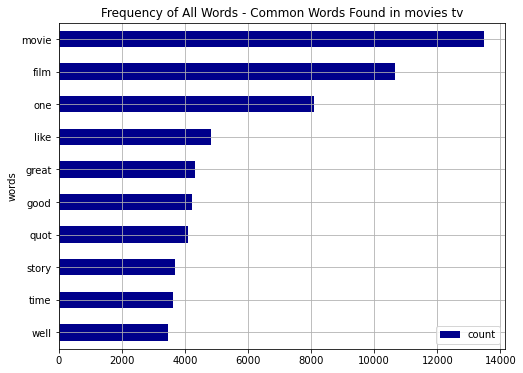

In [29]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='darkblue')
ax.set_title("Frequency of All Words - Common Words Found in movies tv")
plt.grid()
plt.show()

**Analysis:** To calculate these frequent words, the first step is to clear the text column to be analyzed. In this case, all processing is performed on ReviewText (it could also be the Summary column, for example). This data cleaning is mainly focused on the removal of characters that do not contribute to the text analysis, where first the data is converted to lowercase, spaces, exclamation marks, punctuation marks, numeric values, etc. are removed. Subsequently, stop words, which are words that have a high frequency and do not contribute much to the analysis, are cleaned.

After this cleaning process, a tokenization and counting of the words that appear in the text is performed, and then the 10 most frequent words are presented. `movie`, `film` and `one` are the 3 most repeated for the entire dataset.

## Positive reviews 

For this case it is assumed that positive reviews are those that have a rating **greater than or equal to 4.**

In [30]:
# Subset dataset

movies_tv_positive = movies_tv[movies_tv['overall']>= 4]

In [31]:
# Read text column
column_text = movies_tv_positive['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('movie', 10746),
 ('film', 8445),
 ('one', 6663),
 ('great', 3872),
 ('like', 3653),
 ('quot', 3331),
 ('good', 3311),
 ('story', 3017),
 ('time', 2986),
 ('well', 2879)]

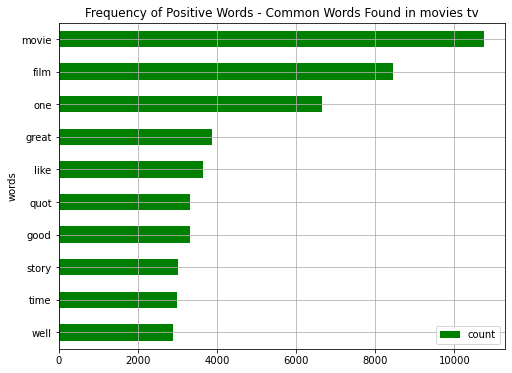

In [32]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='green')
ax.set_title("Frequency of Positive Words - Common Words Found in movies tv")
plt.grid()
plt.show()

**Analyisis:** Now, the exercise asks to perform the same process as above but for the positive reviews. In this case we will use the rating column in order to extract the records with the best ratings, which are expected to have the most positive reviews. To perform the extraction of these records the following logic was used:

`instant_video_positive = instant_video[instant_video['overall']>= 4]`

Note that we will only consider positive records those that have a score of 4 or 5, this is what I considered as positive, and on this set of data we perform all the cleaning processes discussed above.


For this case we find words that represent positive themes, although they are not reflected in the top 3 as you would expect, but we find words like.  `well`,`good`, `great` and `like`

## Negative reviews 

For this case it is assumed that positive reviews are those with a rating **less than 3.**.

In [33]:
# Subset dataset
movies_tv_negative = movies_tv[movies_tv['overall']< 3]

In [34]:
# Read text column
column_text = movies_tv_negative['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('movie', 1390),
 ('film', 1089),
 ('one', 694),
 ('like', 592),
 ('would', 499),
 ('jesus', 469),
 ('quot', 393),
 ('even', 355),
 ('good', 346),
 ('see', 335)]

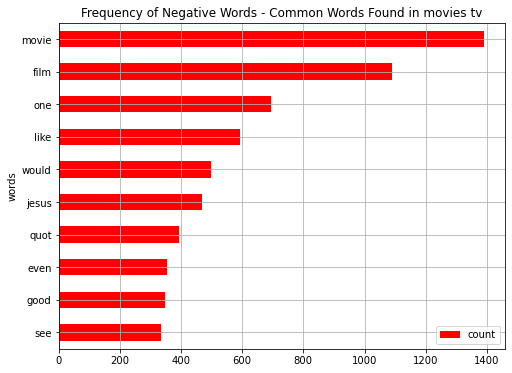

In [35]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='red')
ax.set_title("Frequency of Negative Words - Common Words Found in movies tv")
plt.grid()
plt.show()

**Analyisis:** Now, the exercise asks to perform the same process as the previous one but for the negative ratings. In this case we will use the ratings column to extract the records with the worst ratings, which are the ones expected to have more negative ratings. The following logic has been used to extract these records:

`instant_video_negative = instant_video[instant_video['overall']< 3]`

It should be noted that we will only consider negative records those with a score of 2 or 1, this is what I have considered as negative, and on this data set we perform all the cleaning processes discussed above.

Unlike the previous point, we do not find very negative context words, on the contrary we find words such as `like`, and `good`, which at first glance seems strange because we are using negative reviews. Let's keep exploring!


## Neutral reviews 

For this case it is assumed that positive reviews are those with a rating **equal than 3.**.

In [36]:
# Subset dataset
movies_tv_neutral = movies_tv[movies_tv['overall']== 3]

In [37]:
# Read text column
column_text = movies_tv_neutral['reviewText']
stop_words_english=list(set(stopwords.words('english')))
column_text = pd.DataFrame(column_text)

# Cleaning text column
column_text['reviewText'] = column_text['reviewText'].str.lower()
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: re.sub("\d+", "", x)) #numbers
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: x.split())
column_text['reviewText'] = column_text['reviewText'].apply(lambda x: [item for item in x if item not in stop_words_english])

# Set many list into one single list
allWords = list(itertools.chain.from_iterable(list(column_text['reviewText'])))

# Count most frecuent words
all_words = nltk.FreqDist(w for w in allWords)            # Count all the words in corpus
all_words.most_common(10)   

[('movie', 1338),
 ('film', 1132),
 ('one', 733),
 ('like', 593),
 ('good', 582),
 ('would', 447),
 ('much', 432),
 ('quot', 382),
 ('jesus', 373),
 ('story', 371)]

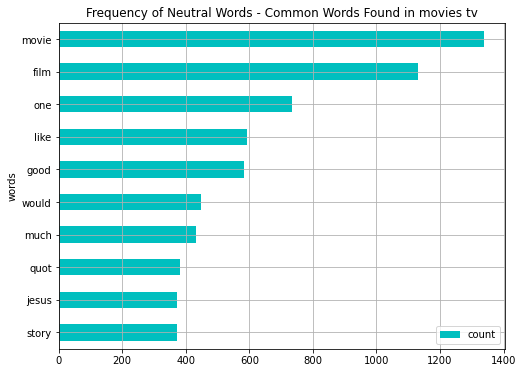

In [38]:
plot_df = pd.DataFrame(all_words.most_common(10) , columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 6))
plot_df.sort_values(by='count').plot.barh(x='words', y='count', ax=ax, color='c')
ax.set_title("Frequency of Neutral Words - Common Words Found in movies tv")
plt.grid()
plt.show()

**Analysis:** Now, although the exercise does not ask for it, I performed the same procedure for neutral valuations. These ratings are those that have a rating exactly equal to 3. Since we split the dataset into negative (<3) and positive (>=4), we use this approach to observe the behavior of the neutrals. The logic to extract the data was as follows:

`instant_video_neutral = instant_video[instant_video['overall']== 3]`

-------

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.**

The words that appear in bad reviews and not in good reviews for the **movies tv** dataset are as follows:


| Words |
| :- | 
| Even |
| Jesus|
| See | 
| Would | 

The words that appear in bad reviews and not in good reviews for the **Instant video** dataset are as follows:


| Words |
| :- | 
| Film |
| Get |
| Movie |
| Really |
| Time |
| Would |


The surprise lies in the fact that these words were expected to express negative feelings, but on the contrary, they are words that do not express very well what they are referring to; it would not be possible to indicate that they are part of a negative review just by reading them, since they are not words in a negative context. Other words were expected

-------

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.**

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
movies_neg_good = movies_tv_negative[movies_tv_negative['reviewText'].str.contains('good', regex=False, 
                                                                                   case=False, na=False)].head(10).reset_index()

movies_neg_good

index     helpful  \
0    186    [13, 23]   
1    405  [113, 119]   
2    473    [66, 68]   
3    503    [15, 19]   
4    576     [9, 28]   
5    595      [1, 8]   
6    614     [9, 52]   
7    634     [9, 32]   
8    639     [8, 20]   
9    651     [7, 21]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [41]:
instant_neg_good =instant_video_negative[instant_video_negative['reviewText'].str.contains('good', regex=False, 
                                                                                          case=False, na=False)].head(10).reset_index()
instant_neg_good

,index,helpful,reviewText,overall,summary,unixReviewTime,datetime,length
0,359,"[0, 0]","I watched this because the Brits usually do a good job with good production values, casting and story lines. However, in this case it proved a waste of 5 hours. The writers, directors and editors should be ashamed to put their names in the credits. Important things happen with no apparent reason and the watcher is left scratching his/her head wondering what was the point. The American general is miscast and not believable. Lots of clicking of computer keyboards for solutions that never seem to work out. The ending stinks!",1,A Good Plot Gone Bad,1395705600,2014-03-25,531
1,738,"[0, 75]","You know the plot. Trashy kids being trashy. The &#34;good&#34; ones are the &#34;poor&#34; ones. The rich trashy kids are just &#34;bad&#34;. Another movie to help the retarded careers of this TV show's actors. They are all old and washed out. But they still try to be hip and cool with their texting and foul mouths, sex videos. Sorry if you can't route for the heroine of the movie it clearly isn't worth watching.",2,boring waste of space,1394755200,2014-03-14,417
2,744,"[2, 3]","There's a scene in Misery where the author writes what he thinks his nurse/tormentor wants to read and suffers for his presumption. Her main problem is the fact that he cheated when he explained that his heroine was alive, but there was also the fact that he was second guessing his audience. Instead of writing something that he could be proud of, he wrote something that he thought that the audience wanted. In many ways, the decline in quality of Veronica Mars reflected this issue. In the third season of Veronica Mars, Rob Thomas veered away from the season long arc and the feminist context and chose instead to focus on shorter story arcs and one-off episodes that didn't tie into the arcs. Instead of making the show easy for potential new fans, Thomas disappointed the existing fans.There was also the issue of the heroine graduating from high school. The teenage detective angle worked better when the setting was high school and there was a great metaphor about tying in hard boiled mysteries with high school where no one really is what they appear to be. Buffy recovered from the same setback, but just barely.This movie tries to go in the opposite direction of the third season by making a movie that is solely for the fans but retains that same desperate &#34;LOVE ME&#34; vibe that wrecked the last season. A little fan service is nice. It's cool to see Mac and Wallace again. Veronica working to solve the case and manipulating the police force to do it is fine. It's even nice to see Veronica and Logan fall into their old patterns.Ken Marino has established himself in comedic roles in shows like Party Down and Children's Hospital so why not bring back Vinnie Van Lowe.Yet, a little goes a long way and too much just becomes aggravating. Do we really need to get Piz again? Especially when he is still the nice guy that Veronica basically ignores. Does Madison have to be a one-dimensional villain ten years later? Weevil shows up to AGAIN end up on the wrong side of the law. Krysten Ritter appears and then reminds everyone who she was in season 2. The only strange moment of restraint in the movie was not bringing back Adam Scott as the teacher who had sex with a student even though the movie revolves around Carrie Bishop who accused him of rape in the Mars vs. Mars episode from season 1. When the ten year reunion has a tribute to the dead classmates, you almost expect it to take over the movie since there were a lot of dead high school students on the show.With all the fan service, the director and writer forget to tell a compelling story. It's a two hour episode with references that require the Veronica Mars wiki to fully get. Unfortunately, as you are referring to the Wiki, you are getting spoiled for the rather pedestrian mystery - which should already be obvious since it follows the &#34;r

**Analysis** Well, although the word good appears in the review, the overall context of the review is negative, this word alone does not fully describe what the user wants to express. You could check, for example, which words accompany the word good to understand it more at the sentence level than the word alone. Another idea is to use bigrams or trigrams in a way that allows to have more analysis at the phrase level than at the token level.

-------

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.**

## 1. The first word after "good"

### 1.1 movies tv negative dataset

In [42]:
# Cleaning text column
stop_words_english=list(set(stopwords.words('english')))

movies_neg_good['reviewText'] = movies_neg_good['reviewText'].str.lower()
movies_neg_good['reviewText'] = movies_neg_good['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
movies_neg_good['reviewText'] = movies_neg_good['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
movies_neg_good['reviewText'] = movies_neg_good['reviewText'].apply(lambda x: x.translate(str.maketrans('', '',
                                                                                                        string.punctuation)))

pat = r'\b(?:{})\b'.format('|'.join(stop_words_english))
movies_neg_good['reviewText'] = movies_neg_good['reviewText'].str.replace(pat, '')


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [43]:
# Words after "good" with clean dataset
for i in movies_neg_good.itertuples():
    temp = movies_neg_good['reviewText'][i.Index].split("good")[1].split()[0]
    print(temp)

story
scene
us
vs
plot
cinema
history
anyone
idolatrous
christians


**Analysis** For this occasion, the entire cleaning process that was carried out in previous points was performed in order to have consistent results with what is being studied, since by not cleaning the data, several reviews could be omitted due to punctuation issues, capitalization, lowercase, and the idea is to be able to analyze all the information. In this case we clean the dataset containing the first 10 reviews with negative reviews and then print the words that are after the word good. We observe words like `story`, `scene`, which would be `Good Story`, `Good Scene`, *however we find under scenarios of negative ratings, which is strange*. We must continue to explore!

### 1.2 instant video negative tv dataset

In [44]:
# Cleaning text column
stop_words_english=list(set(stopwords.words('english')))

instant_neg_good['reviewText'] = instant_neg_good['reviewText'].str.lower()
instant_neg_good['reviewText'] = instant_neg_good['reviewText'].apply(lambda x: re.sub(r'\W',' ',re.sub(r'\s+',' ',x)))
instant_neg_good['reviewText'] = instant_neg_good['reviewText'].apply(lambda x: re.sub('¡','',re.sub('°','',x)))
instant_neg_good['reviewText'] = instant_neg_good['reviewText'].apply(lambda x: x.translate(str.maketrans('', '',
                                                                                                          string.punctuation)))

pat = r'\b(?:{})\b'.format('|'.join(stop_words_english))
instant_neg_good['reviewText'] = instant_neg_good['reviewText'].str.replace(pat, '')


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [45]:
# Words after "good" with clean dataset
for i in instant_neg_good.itertuples():
    temp = instant_neg_good['reviewText'][i.Index].split("good")[1].split()[0]
    print(temp)

job
34
movie
set
yuck
tv
enjoy
guess
acting
actors


**Analysis** For this occasion, the entire cleaning process that was carried out in previous points was performed in order to have consistent results with what is being studied, since by not cleaning the data, several reviews could be omitted due to punctuation issues, capitalization, lowercase, and the idea is to be able to analyze all the information. In this case we clean the dataset containing the first 10 reviews with negative reviews and then print the words that are after the word good. We observe words like `job`, `movie`, which would be `Good job`, `Good movie`, *however we find under scenarios of negative ratings, which is strange*. We must continue to explore!

## 2. The first word after "good" that is a noun or cardinal

In [46]:
from nltk.tag import pos_tag

### 2.1 movies tv negative dataset

In [47]:
movies_neg_good2 = movies_neg_good.copy()

In [48]:
# Words after "good" with clean dataset
word = 'good'

for i in movies_neg_good2.itertuples():
    print(i.Index)
    a = movies_neg_good2['reviewText'][i.Index].split(word)[1:]
    a = ",".join(a)
    a = a.split()
    if ',' in a:
        a.remove(',')
    
    for j in range(0,len(a)):
        temp = a[j]
        temp = nltk.word_tokenize(temp)
        pos = nltk.pos_tag(temp)

        if pos[0][1] in ('NN','CD'):
            print(pos)
            break

0
[('story', 'NN')]
1
[('scene', 'NN')]
2
[('spoken', 'NN')]
3
[('vs', 'NN')]
4
[('plot', 'NN')]
5
[('cinema', 'NN')]
6
[('history', 'NN')]
7
[('anyone', 'NN')]
8
[('fan', 'NN')]
9
[('america', 'NN')]


**Analysis:** For this occasion all the words that were found after the word then were searched, in case the word was more than once in the revision, all the following words were joined in a list, giving priority to the first occurrence of the word well. The next command allow to concat all the words next to `good` 

`movies_neg_good2['reviewText'][i.Index].split(word)[1:]`

Then, it was structured so that it could be used as input in the nltk tokenize and likewise for the pos_tag, once the input structure is good it goes through these functions and performs a validation of the immediately following word, if this is not substantive or cardinal, then it goes to the next one, and so on until it finds a word that is substantive or cardinal, and when it finds it it prints it on screen and its respective tag.

This time the first words they found were nouns and not cardinals. Let's keep exploring, the results are very interesting.

### 2.2 instant video negative tv dataset

In [49]:
instant_neg_good2 = instant_neg_good.copy()

In [50]:
# Words after "good" with clean dataset
word = 'good'

for i in instant_neg_good2.itertuples():
    print(i.Index)
    a = instant_neg_good2['reviewText'][i.Index].split(word)[1:]
    a = ",".join(a)
    a = a.split()
    if ',' in a:
        a.remove(',')
    
    for j in range(0,len(a)):
        temp = a[j]
        temp = nltk.word_tokenize(temp)
        pos = nltk.pos_tag(temp)

        if pos[0][1] in ('NN','CD'):
            print(pos)
            break

0
[('job', 'NN')]
1
[('34', 'CD')]
2
[('movie', 'NN')]
3
[('set', 'NN')]
4
[('yuck', 'NN')]
5
[('tv', 'NN')]
6
[('enjoy', 'NN')]
7
[('guess', 'NN')]
8
[('end', 'NN')]
9
[('play', 'NN')]


**Analysis:** This time we perform the same procedure as above, but this time for the instant video dataset. Like the previous script, the following command allows to fetch all the words after the word good:

`instant_neg_good2['reviewText'][i.Index].split(word)[1:]`

In these results if we find a cardinal word, in review 2 (index 1) we find that the number 34 is the cardinal word followed by good. The rest of the words are of noun type

## 3. The last word before "good" that is a noun or cardinal

### 2.1 movies tv negative dataset

In [51]:
movies_neg_good3 = movies_neg_good.copy()

In [52]:
# Words before "good" with clean dataset
word = 'good'

for i in movies_neg_good3.itertuples():
    print(i.Index)
    a = movies_neg_good3['reviewText'][i.Index].split(word)[:1]
    a = ",".join(a)
    a = a.split()
    if ',' in a:
        a.remove(',')
    
    for j in range(0,len(a)):
        temp = a[j]
        temp = nltk.word_tokenize(temp)
        pos = nltk.pos_tag(temp)

        if pos[0][1] in ('NN','CD'):
            print(pos)
            break

0
1
[('dvd', 'NN')]
2
[('edit', 'NN')]
3
[('icon', 'NN')]
4
[('mel', 'NN')]
5
[('5', 'CD')]
6
[('movie', 'NN')]
7
[('film', 'NN')]
8
[('saw', 'NN')]
9
[('problem', 'NN')]


**Analysis:** For this occasion all the words that were found before the word then were searched. The next command allow to concat all the words next to `good` 

`movies_neg_good3['reviewText'][i.Index].split(word)[:1]`

Then, it was structured so that it could be used as input in the nltk tokenize and likewise for the pos_tag, once the input structure is good it goes through these functions and performs a validation of the immediately before word, if this is not substantive or cardinal, then it goes to the next one, and so on until it finds a word that is substantive or cardinal, and when it finds it it prints it on screen and its respective tag. For this occasion it found a cardinal word in review 6 of the dataset (index 5), the rest are noun

### 2.2 instant video negative tv dataset

In [53]:
instant_neg_good3 = instant_neg_good.copy()

In [54]:
# Words before "good" with clean dataset
word = 'good'

for i in instant_neg_good3.itertuples():
    print(i.Index)
    a = instant_neg_good3['reviewText'][i.Index].split(word)[:1]
    a = ",".join(a)
    a = a.split()
    if ',' in a:
        a.remove(',')
    #print(a)
    
    for j in range(0,len(a)):
        temp = a[j]
        temp = nltk.word_tokenize(temp)
        pos = nltk.pos_tag(temp)

        if pos[0][1] in ('NN','CD'):
            print(pos)
            break

0
1
[('plot', 'NN')]
2
[('scene', 'NN')]
3
[('ok', 'NN')]
4
[('waste', 'NN')]
5
[('character', 'NN')]
6
[('one', 'CD')]
7
[('show', 'NN')]
8
[('two', 'CD')]
9
[('love', 'NN')]


**Analysis:** This time we perform the same procedure as above, but this time for the instant video dataset. Like the previous script, the following command allows to fetch all the words after the word good:

`instant_neg_good3['reviewText'][i.Index].split(word)[:1]`

This case is interesting, because it found two words of cardinal type and they are not specifically a number but they refer to one of them but in written form. The number 5 and the number 2. The algorithm works very well!

-------

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.** **A function was created to this excercise. Using case 5.3**

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

## Function for extracting the most frequent words
## This function was taken from correlation one case 5.3. 
## No significant changes were made.

def common_words_ngrams(corpus, n=5,k=1):
    # Train countvectorizer with input corpus and personalizate n grams 
    # Here the stopwords are remove
    vec = CountVectorizer(ngram_range=(k,k),                          
                          stop_words = 'english').fit(corpus)
    
    # Creation of bag of words from all corpus
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    # Count how many times the ngram appears
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # order from most to least occurrences
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # Return the number n (personalizate in input) of most frequents ngrams
    return words_freq[:n]

**Analysis:**This function was used from case 5.3 of the course and was adapted to solve this problem.

### 5.1.1 movies tv POSITIVE dataset

In [56]:
movies_tv_positive = movies_tv[movies_tv['overall']>= 4]

Look the **top 5** most frequent **bigrams in movie tv postive dataset**

In [57]:
common_words_ngrams(movies_tv_positive['reviewText'],5,2)

[('blu ray', 646),
 ('sci fi', 470),
 ('mel gibson', 434),
 ('special effects', 417),
 ('great movie', 377)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a bigram and print the top 5 most repeated bigrams in this dataset.

Now, we are working in the context of positive reviews and with a bigram analysis, which could provide better information than at the level of a single word, in this case we find interesting the word mel gibson (Actor) as it may be referring to a movie where this actor appears. And on the other hand, special effects, which could mean that people like special effects movies.

Look the **top 5** most frequent **trigrams in movie tv positive dataset**

In [58]:
common_words_ngrams(movies_tv_positive['reviewText'],5,3)

[('tommy lee jones', 132),
 ('world war ii', 102),
 ('close encounters kind', 88),
 ('red nosed reindeer', 68),
 ('12 year old', 68)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a trigrams and print the top 5 most repeated trigrams in this dataset.

Now, we are working in the context of positive reviews and with a trigram analysis, which could provide better information than at the level of 1 single word or even 2, in this case we find interesting the word tommy lee jones as it may be referring to a movie where this person appears. And on the other hand, world war ii, which could mean that people like movies of this theme or a movie that has this specific name.

### 5.1.2 movies tv NEGATIVE dataset

In [59]:
movies_tv_negative = movies_tv[movies_tv['overall']< 3]

Look the **top 5** most frequent **bigrams in movie tv negative dataset**

In [60]:
common_words_ngrams(movies_tv_negative['reviewText'],5,2)

[('mel gibson', 87),
 ('passion christ', 65),
 ('special effects', 55),
 ('jesus christ', 44),
 ('jane eyre', 43)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a bigram and print the top 5 most repeated bigrams in this dataset.

Now, we are working in the context of the negative reviews and with a bigram analysis, which could provide better information than at the level of a single word, in this case we find interesting the word passion christ as it may be referring to the movie as such and that people did not like it, likewise mel gibson appears again which can be interpreted as having a division between people who like it and others who do not like it so much.

Look the **top 5** most frequent **trigrams in movie tv negative dataset**

In [61]:
common_words_ngrams(movies_tv_negative['reviewText'],5,3)

[('blu ray player', 11),
 ('gibson passion christ', 9),
 ('waste time money', 8),
 ('don waste time', 7),
 ('12 year old', 7)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a trigrams and print the top 5 most repeated trigrams in this dataset.

In this case we find interesting the word gibson passion christ as it confirms what we observed in the bigram and that is that some people did not like the movie, we also find words like don waste time or waste time money which are very negative contexts for movie reviews.

### 5.2.1 Instant video POSITIVE dataset

In [62]:
instant_video_positive = instant_video[instant_video['overall']>= 4]

Look the **top 5** most frequent **bigrams in Instant video postive dataset**

In [63]:
common_words_ngrams(instant_video_positive['reviewText'],5,2)

[('story line', 944),
 ('second season', 643),
 ('sci fi', 588),
 ('story lines', 566),
 ('ve seen', 564)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a bigram and print the top 5 most repeated bigrams in this dataset.

Now, we are working in the context of positive reviews and with a bigram analysis, which could provide better information than at the level of a single word. In this case it is interesting to note words such as second season which can refer to a movie as such, a scene, or some kind of series.

Look the **top 5** most frequent **trigrams in Instant video postive dataset**

In [64]:
common_words_ngrams(instant_video_positive['reviewText'],5,3)

[('looking forward season', 164),
 ('keeps getting better', 106),
 ('great story line', 98),
 ('love love love', 92),
 ('does great job', 92)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a trigrams and print the top 5 most repeated trigrams in this dataset.

Now, we are working in the context of positive reviews and with a trigram analysis, which could provide better information than at the level of 1 single word or even 2. In this case we find the word looking forward season which is very similar to the one found in bigrams, we find great story line which and does great job. Of course, we are working with positive reviews, which is expected for this type of words.

### 5.2.2 Instant video NEGATIVE dataset

In [65]:
instant_video_negative = instant_video[instant_video['overall']< 3]

Look the **top 5** most frequent **bigrams in Instant video negative dataset**

In [66]:
common_words_ngrams(instant_video_negative['reviewText'],5,2)

[('waste time', 150),
 ('story line', 116),
 ('ve seen', 114),
 ('don know', 102),
 ('sci fi', 92)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a bigram and print the top 5 most repeated bigrams in this dataset.

Now, we are working in the context of negative reviews and with a bigram analysis, which could provide better information than at the level of a single word. In this one the word "waste time" appears, which again is not a good thing in movie comments and it would be necessary to check which movies it refers to in order to better understand the user.

Look the **top 5** most frequent **trigrams in Instant video negative dataset**

In [67]:
common_words_ngrams(instant_video_negative['reviewText'],5,3)

[('don waste time', 43),
 ('really wanted like', 24),
 ('parental guide bomb', 14),
 ('big bang theory', 13),
 ('waste time money', 12)]

**Analysis:** The function has three input parameters: the corpus, the ngram you want to use (1=token, 2=bigram, 3=trigram), and the number of most frequent words you want to print. In this case, we used a trigrams and print the top 5 most repeated trigrams in this dataset.

In this case we found don waste time again, it seems that this word is very common in negative contexts, we also observed really wanted like which could be the name of a movie, big bang theory which is clearly a very well known series but apparently the users of this dataset did not like it very much.

-------

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**
A proposal to have this relevant information consists of lemmatizing the words and assigning grammatical information to them based on their definition and context (post_tag). 

Once this process is done, I would perform several iterations between ngram, bigram and trigram to understand which of these best approximates my problem and my context without leaving aside the grammatical analysis.

I would also take into account the frequency of occurrences of the words with their respective tags. And I would search according to the context that is being worked on which would be the possible informative candidate words.

In this way, taking into account what kind of grammatical information I have, understanding the context of the dataset I am analyzing, and by means of frequencies of the informative words that appear the most, I propose to extract a top n of possible best informative words.

-------

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

### Create the function

In [68]:
def exc7_nlp(corpus):
    # empty list to save info
    prueba = []
    nouns = []
    adj =  []
    
    # token and pos the sentence
    temp = nltk.word_tokenize(corpus)
    pos2 = nltk.pos_tag(temp)
    
    # validate which word are noun or adjective
    # and save into list
    
    for i in range(0,len(temp)):
        if pos2[i][1] in ['NN']:
            nouns.append(pos2[i])
        elif pos2[i][1] in ['JJ']:
            adj.append(pos2[i])
    
    #create the combinations of adj and nouns
    for x in range(0,len(adj)):
        for z in range(0,len(nouns)):
            prueba.append(adj[x][0] + ' '+ nouns[z][0])
    
    # return the combinantions
    return prueba

**Analysis** This function receives a sentence, which is a text like the ones we previously analyzed in the movie datasets. To this sentence we apply the simple tokenization and then we apply the pos_tag, both functions using nltk. Afterwards we evaluate the type of tag that each output has and we store only those that are nouns and adjectives, and then we combine the adjective with the noun.

### Example 1

In [69]:
sentence = "That was a good, long movie"

In [70]:
exc7_nlp(sentence)

['good movie', 'long movie']

### Example 1

In [71]:
sentence2 = "The book was great and very large"

In [72]:
exc7_nlp(sentence2)

['great book', 'large book']

### Example 3

In [73]:
sentence3 = "This apple is soft, big and very green"

In [74]:
exc7_nlp(sentence3)

['soft apple', 'big apple', 'green apple']

The results obtained by the function are very interesting, since it is possible to obtain a main idea of the sentence using these nltk functions and thus have a better context about what is being analyzed beyond having a single ngram or bigram. Since they take into account a more semantic issue.

-------